### Make maps of ToE forr Sea ice area (SON), NPP (ONDJFM), and zooC (JFM), KGP (JFM), fish (annual), ice fish (annual), emperors (annual), adelies (annual)

In [1]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
import pop_tools
import warnings
warnings.filterwarnings('ignore')
import cartopy
import cartopy.crs as ccrs
import utils
from glob import glob
import numpy as np
import matplotlib.path as mpath

import cmocean
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

### Get grid info

In [2]:
ds_grid = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)
area_km2 = area * 1e-10

In [3]:
years = np.arange(1920,2101,1)

In [4]:
years = xr.DataArray(years,dims=('time'))

### Make a SIZ mask, so then we can do an area-weighted average for each longitude

In [5]:
##
ds_siz_mask = xr.open_dataset('/glade/u/home/kristenk/antarc_marine_pred_work/TOE/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))

In [6]:
siz_mask = ds_siz_mask.SIZ

### Add maps below for each variable

    • ICE - OND & JFM
    • NPP - OND & JFM
    • KGP = OND & JFM


In [7]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(file)
ds_npp = ds_npp.isel(time=slice(70,250))
ds_npp = ds_npp.isel(nlat=slice(0,55))

In [8]:
ds_npp.NPP_ONDJFM.attrs

{'units': 'mmol/m2/season'}

In [9]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-means-IFRAC-hi_v4.nc'
ds_ice = xr.open_dataset(file)
ds_ice = ds_ice.isel(time=slice(70,250))
ds_ice

<xarray.Dataset>
Dimensions:       (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time          (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    IFRAC_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    IFRAC_OND     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JFM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JAS     (time, member_id, nlat, nlon) float64 ...
    IFRAC_SON     (time, member_id, nlat, nlon) float64 ...
    IFRAC_MAM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_AMJ     (time, member_id, nlat, nlon) float64 ...
    SIT_OND       (time, member_id, nlat, nlon) float64 ...
    SIT_JFM       (time, member_id, nlat, nlon) float64 ...
    SIT_AMJ       (time, member_id, nlat, nlon) float64 ...
    SIT_JAS       (time, member_id, nlat, nlon) float64 ...
    SIT_ONDJFM    (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly ifrac in the Southern Ocean from 1850 to 2099. Ea...

In [10]:
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(file)
ds_kgp = ds_kgp.isel(nlat=slice(0,55))
ds_kgp = ds_kgp.isel(time=slice(70,250))
ds_kgp

<xarray.Dataset>
Dimensions:     (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * time        (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    KGP_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    KGP_OND     (time, member_id, nlat, nlon) float64 ...
    KGP_JFM     (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2024-01-23
    contents:        yearly KGP in the Southern Ocean from 1850 to 2099. Each...

In [11]:
#### mask out placse in the KGP dataset that are:
### 1) outside of the SIZ
### 2) less than one (these = 0)
### 3) KGP during base period too low to reliably estimate standard deviation and therefore ToE


ds_kgp = ds_kgp.where(ds_siz_mask.SIZ ==1)

In [12]:
for var in ['KGP_ONDJFM','KGP_OND','KGP_JFM']:
    ds_kgp[var] = ds_kgp[var].where(ds_kgp[var] >= 0, other=0).where(ds_grid.REGION_MASK >0)

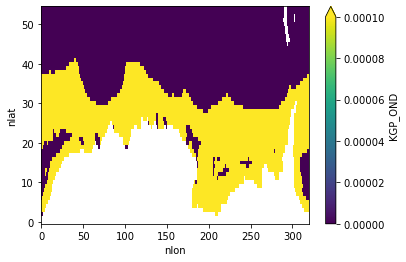

In [13]:
ds_kgp.KGP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')).plot(vmin=0,vmax=0.0001)

In [14]:
basep_kgp_ond = ds_kgp.KGP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id'))
basep_kgp_jfm = ds_kgp.KGP_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id'))

In [15]:
endc_kgp_ond = ds_kgp.KGP_OND.isel(time=slice(170,180)).mean(dim=('time','member_id'))
endc_kgp_jfm = ds_kgp.KGP_JFM.isel(time=slice(170,180)).mean(dim=('time','member_id'))

In [16]:
ds_kgp['KGP_OND'] = ds_kgp.KGP_OND.where(basep_kgp_ond > 0.001)

In [17]:
ds_kgp['KGP_JFM'] = ds_kgp.KGP_JFM.where(basep_kgp_jfm > 0.001)

In [18]:
ones = np.full((55,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [19]:
ond_kgp_mask = ones.where(ds_kgp.KGP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')) < 0.0001).where(endc_kgp_ond > 0.01)
#ond_kgp_mask.plot()

In [20]:
jfm_kgp_mask = ones.where(ds_kgp.KGP_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id')) < 0.0001) #.where(endc_kgp_jfm > 0.01)
#jfm_kgp_mask.plot()

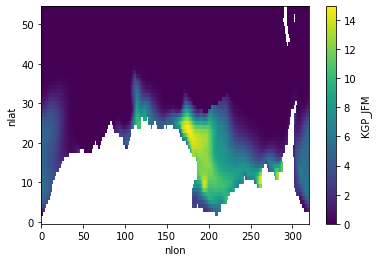

In [21]:
endc_kgp_jfm.plot()

### Put all these together into one dataset

In [22]:
ds = xr.Dataset()
ds['NPP_ONDJFM'] = ds_npp.NPP_ONDJFM
ds['NPP_OND'] = ds_npp.NPP_OND
ds['NPP_JFM'] = ds_npp.NPP_JFM
ds['NPP_AMJ'] = ds_npp.NPP_AMJ
ds['NPP_JAS'] = ds_npp.NPP_JAS
ds['IFRAC_AMJ'] = ds_ice.IFRAC_AMJ
ds['IFRAC_JAS'] = ds_ice.IFRAC_JAS
ds['IFRAC_OND'] = ds_ice.IFRAC_OND
ds['IFRAC_JFM'] = ds_ice.IFRAC_JFM
ds['SIT_JAS'] = ds_ice.SIT_JAS
ds['SIT_AMJ'] = ds_ice.SIT_AMJ
ds['SIT_JFM'] = ds_ice.SIT_JFM
ds['SIT_OND'] = ds_ice.SIT_OND
ds['SIT_ONDJFM'] = ds_ice.SIT_ONDJFM
ds['IFRAC_ONDJFM'] = ds_ice.IFRAC_ONDJFM
ds['KGP_JFM'] = ds_kgp.KGP_JFM
ds['KGP_OND'] = ds_kgp.KGP_OND
ds['KGP_ONDJFM'] = ds_kgp.KGP_ONDJFM

### Calculate ToE of seasonal sums/means

In [23]:
time3d = np.full([180,55,320],1,dtype=int)

In [24]:
ylen = 55
xlen = 320

for x in np.arange(0,xlen,1):
    for y in np.arange(0,ylen,1):

        time3d[:,y,x]=ds.time.values

time3d = xr.DataArray(time3d,dims=('time','nlat','nlon'))

#### calculate up/low thresholds for NPP, zooC, ice

In [28]:
%%time

# #### empty dictionaries, keys are variable names
upthres_ds = xr.Dataset()
lothres_ds = xr.Dataset()

variables=['IFRAC_ONDJFM','IFRAC_OND','IFRAC_JFM','SIT_OND','SIT_JFM','SIT_AMJ','SIT_JAS','SIT_ONDJFM',
           'NPP_ONDJFM','NPP_OND','NPP_JFM','KGP_JFM','NPP_AMJ','NPP_JAS',
           'KGP_OND','KGP_ONDJFM','IFRAC_AMJ','IFRAC_JAS']

for var in variables:
    
    ### calculate                                                                                                                                                                                                                                                                 
    mean_var = ds[var].isel(time=slice(0,30)).mean(dim=('time','member_id'))
    std_var = ds[var].isel(time=slice(0,30)).std(dim=('member_id','time'))
    
    var_array_upthres = mean_var + 2 * std_var
    var_array_lothres = mean_var - 2 * std_var

    upthres_ds[var] = var_array_upthres
    lothres_ds[var] = var_array_lothres

CPU times: user 2.67 s, sys: 2.73 s, total: 5.4 s
Wall time: 7.54 s


In [29]:
ToE_up_npp_ondjfm = time3d.where(ds.NPP_ONDJFM.mean(dim='member_id') > upthres_ds['NPP_ONDJFM'])
ToE_up_npp_ondjfm = ToE_up_npp_ondjfm.min(dim='time')

ToE_up_npp_ond = time3d.where(ds.NPP_OND.mean(dim='member_id') > upthres_ds['NPP_OND'])
ToE_up_npp_ond = ToE_up_npp_ond.min(dim='time')

ToE_up_npp_jfm = time3d.where(ds.NPP_JFM.mean(dim='member_id') > upthres_ds['NPP_JFM'])
ToE_up_npp_jfm = ToE_up_npp_jfm.min(dim='time')

ToE_up_npp_amj = time3d.where(ds.NPP_AMJ.mean(dim='member_id') > upthres_ds['NPP_AMJ'])
ToE_up_npp_amj = ToE_up_npp_amj.min(dim='time')

ToE_up_npp_jas = time3d.where(ds.NPP_JAS.mean(dim='member_id') > upthres_ds['NPP_JAS'])
ToE_up_npp_jas = ToE_up_npp_jas.min(dim='time')


In [30]:
ToE_down_npp_ondjfm = time3d.where(ds.NPP_ONDJFM.mean(dim='member_id') < lothres_ds['NPP_ONDJFM'])
ToE_down_npp_ondjfm = ToE_down_npp_ondjfm.min(dim='time')

ToE_down_npp_ond = time3d.where(ds.NPP_OND.mean(dim='member_id') < lothres_ds['NPP_OND'])
ToE_down_npp_ond = ToE_down_npp_ond.min(dim='time')

ToE_down_npp_jfm = time3d.where(ds.NPP_JFM.mean(dim='member_id') < lothres_ds['NPP_JFM'])
ToE_down_npp_jfm = ToE_down_npp_jfm.min(dim='time')

ToE_down_npp_amj = time3d.where(ds.NPP_AMJ.mean(dim='member_id') < lothres_ds['NPP_AMJ'])
ToE_down_npp_amj = ToE_down_npp_amj.min(dim='time')

ToE_down_npp_jas = time3d.where(ds.NPP_JAS.mean(dim='member_id') < lothres_ds['NPP_JAS'])
ToE_down_npp_jas = ToE_down_npp_jas.min(dim='time')

In [32]:
ToE_up_ice_amj = time3d.where(ds.IFRAC_AMJ.mean(dim='member_id') > upthres_ds['IFRAC_AMJ'])
ToE_up_ice_amj = ToE_up_ice_amj.min(dim='time')

ToE_up_ice_jas = time3d.where(ds.IFRAC_JAS.mean(dim='member_id') > upthres_ds['IFRAC_JAS'])
ToE_up_ice_jas = ToE_up_ice_jas.min(dim='time')

ToE_up_ice_ond = time3d.where(ds.IFRAC_OND.mean(dim='member_id') > upthres_ds['IFRAC_OND'])
ToE_up_ice_ond = ToE_up_ice_ond.min(dim='time')

ToE_up_ice_jfm = time3d.where(ds.IFRAC_JFM.mean(dim='member_id') > upthres_ds['IFRAC_JFM'])
ToE_up_ice_jfm = ToE_up_ice_jfm.min(dim='time')

ToE_up_ice_ondjfm = time3d.where(ds.IFRAC_ONDJFM.mean(dim='member_id') > upthres_ds['IFRAC_ONDJFM'])
ToE_up_ice_ondjfm = ToE_up_ice_ondjfm.min(dim='time')

In [33]:
ToE_down_ice_amj = time3d.where(ds.IFRAC_AMJ.mean(dim='member_id') < lothres_ds['IFRAC_AMJ'])
ToE_down_ice_amj = ToE_down_ice_amj.min(dim='time')

ToE_down_ice_jas = time3d.where(ds.IFRAC_JAS.mean(dim='member_id') < lothres_ds['IFRAC_JAS'])
ToE_down_ice_jas = ToE_down_ice_jas.min(dim='time')

ToE_down_ice_ond = time3d.where(ds.IFRAC_OND.mean(dim='member_id') < lothres_ds['IFRAC_OND'])
ToE_down_ice_ond = ToE_down_ice_ond.min(dim='time')

ToE_down_ice_jfm = time3d.where(ds.IFRAC_JFM.mean(dim='member_id') < lothres_ds['IFRAC_JFM'])
ToE_down_ice_jfm = ToE_down_ice_jfm.min(dim='time')

ToE_down_ice_ondjfm = time3d.where(ds.IFRAC_ONDJFM.mean(dim='member_id') < lothres_ds['IFRAC_ONDJFM'])
ToE_down_ice_ondjfm = ToE_down_ice_ondjfm.min(dim='time')

In [34]:
ToE_down_SIT_ond = time3d.where(ds.SIT_OND.mean(dim='member_id') < lothres_ds['SIT_OND'])
ToE_down_SIT_ond = ToE_down_SIT_ond.min(dim='time')

ToE_down_SIT_jfm = time3d.where(ds.SIT_JFM.mean(dim='member_id') < lothres_ds['SIT_JFM'])
ToE_down_SIT_jfm = ToE_down_SIT_jfm.min(dim='time')

ToE_up_SIT_ond = time3d.where(ds.SIT_OND.mean(dim='member_id') > upthres_ds['SIT_OND'])
ToE_up_SIT_ond = ToE_up_SIT_ond.min(dim='time')

ToE_up_SIT_jfm = time3d.where(ds.SIT_JFM.mean(dim='member_id') > upthres_ds['SIT_JFM'])
ToE_up_SIT_jfm = ToE_up_SIT_jfm.min(dim='time')

ToE_up_SIT_ondjfm = time3d.where(ds.SIT_ONDJFM.mean(dim='member_id') > upthres_ds['SIT_ONDJFM'])
ToE_up_SIT_ondjfm = ToE_up_SIT_ondjfm.min(dim='time')

ToE_down_SIT_ondjfm = time3d.where(ds.SIT_ONDJFM.mean(dim='member_id') < lothres_ds['SIT_ONDJFM'])
ToE_down_SIT_ondjfm = ToE_down_SIT_ondjfm.min(dim='time')

In [35]:
ToE_down_SIT_amj = time3d.where(ds.SIT_AMJ.mean(dim='member_id') < lothres_ds['SIT_AMJ'])
ToE_down_SIT_amj = ToE_down_SIT_amj.min(dim='time')

ToE_down_SIT_jas = time3d.where(ds.SIT_JAS.mean(dim='member_id') < lothres_ds['SIT_JAS'])
ToE_down_SIT_jas = ToE_down_SIT_jas.min(dim='time')

ToE_up_SIT_amj = time3d.where(ds.SIT_AMJ.mean(dim='member_id') > upthres_ds['SIT_AMJ'])
ToE_up_SIT_amj = ToE_up_SIT_amj.min(dim='time')

ToE_up_SIT_jas = time3d.where(ds.SIT_JAS.mean(dim='member_id') > upthres_ds['SIT_JAS'])
ToE_up_SIT_jas = ToE_up_SIT_jas.min(dim='time')

In [36]:
ToE_up_kgp_ondjfm = time3d.where(ds.KGP_ONDJFM.mean(dim='member_id') > upthres_ds['KGP_ONDJFM'])
ToE_up_kgp_ondjfm = ToE_up_kgp_ondjfm.min(dim='time')

ToE_up_kgp_ond = time3d.where(ds.KGP_OND.mean(dim='member_id') > upthres_ds['KGP_OND'])
ToE_up_kgp_ond = ToE_up_kgp_ond.min(dim='time')

ToE_up_kgp_jfm = time3d.where(ds.KGP_JFM.mean(dim='member_id') > upthres_ds['KGP_JFM'])
ToE_up_kgp_jfm = ToE_up_kgp_jfm.min(dim='time')

In [37]:
ToE_down_kgp_ondjfm = time3d.where(ds.KGP_ONDJFM.mean(dim='member_id') < lothres_ds['KGP_ONDJFM'])
ToE_down_kgp_ondjfm = ToE_down_kgp_ondjfm.min(dim='time')

ToE_down_kgp_ond = time3d.where(ds.KGP_OND.mean(dim='member_id') < lothres_ds['KGP_OND'])
ToE_down_kgp_ond = ToE_down_kgp_ond.min(dim='time')

ToE_down_kgp_jfm = time3d.where(ds.KGP_JFM.mean(dim='member_id') < lothres_ds['KGP_JFM'])
ToE_down_kgp_jfm = ToE_down_kgp_jfm.min(dim='time')

### Make some maps of each variable

In [38]:
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

## NPP

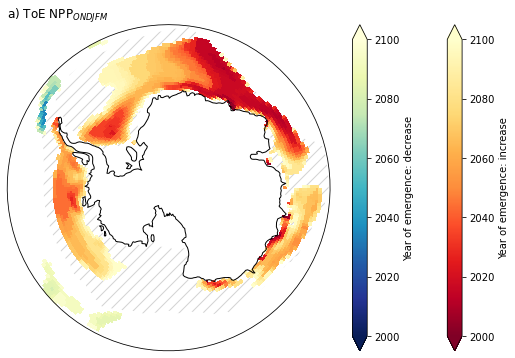

In [39]:
fig = plt.figure(figsize=(10,6))

######## ToE NPP increase #################################################
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE NPP$_{ONDJFM}$', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_ondjfm)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_ondjfm)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

cbar1 = fig.colorbar(pc1, extend='both',label='Year of emergence: increase')
cbar1 = fig.colorbar(pc2, extend='both',label='Year of emergence: decrease')
#fig.savefig('/glade/work/kristenk/figs/fig_TOE_Krill_growth_pot.png', bbox_inches='tight', dpi=300, format='png');

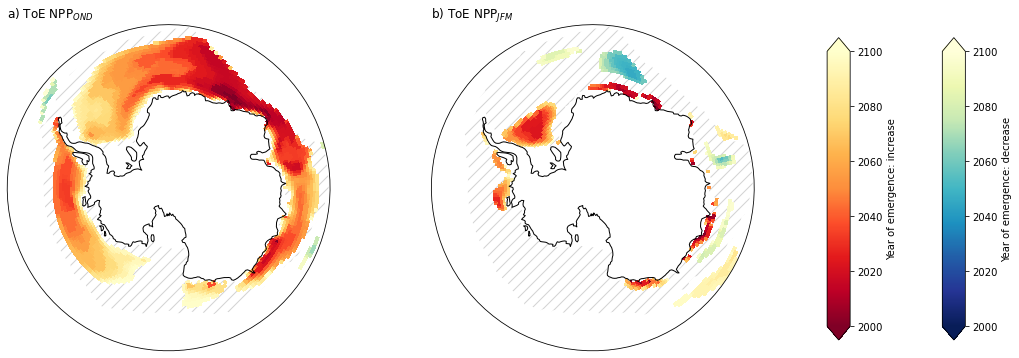

In [40]:
fig = plt.figure(figsize=(16,6))

######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE NPP$_{OND}$', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_ond)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_ond)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

# cbar1 = fig.colorbar(pc1, extend='both',label='Year of emergence: increase')
# cbar1 = fig.colorbar(pc2, extend='both',label='Year of emergence: decrease')
# #fig.savefig('/glade/work/kristenk/figs/fig_TOE_Krill_growth_pot.png', bbox_inches='tight', dpi=300, format='png');

######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE NPP$_{JFM}$', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_jfm)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_jfm)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label='Year of emergence: decrease')
#fig.savefig('/glade/work/kristenk/figs/fig_TOE_Krill_growth_pot.png', bbox_inches='tight', dpi=300, format='png');

### ICE

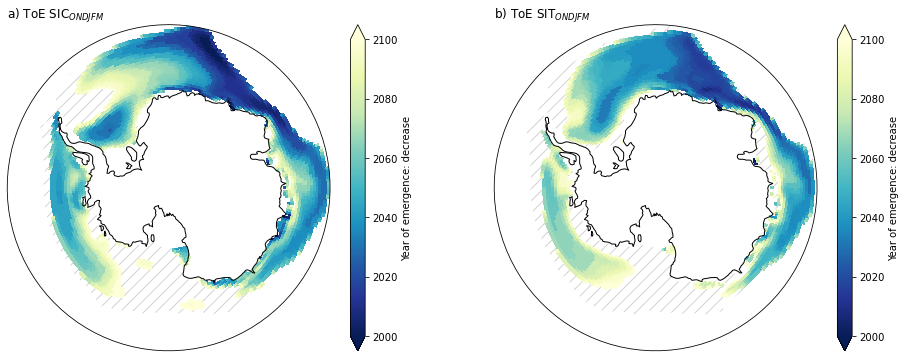

In [41]:
fig = plt.figure(figsize=(16,6))

######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE SIC$_{ONDJFM}$', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

# lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_ice_son)

# pc1 = ax.pcolormesh(lon,lat,field,
#                     transform=ccrs.PlateCarree(),
#                    cmap='Reds_r',
#                    vmin=2000,vmax=2100
#                   )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_ondjfm)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

# cbar1 = fig.colorbar(pc1, extend='both',label='Year of emergence: increase')
cbar1 = fig.colorbar(pc2, extend='both',label='Year of emergence: decrease')


######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE SIT$_{ONDJFM}$', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

# lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_ice_son)

# pc1 = ax.pcolormesh(lon,lat,field,
#                     transform=ccrs.PlateCarree(),
#                    cmap='Reds_r',
#                    vmin=2000,vmax=2100
#                   )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_ondjfm)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

# cbar1 = fig.colorbar(pc1, extend='both',label='Year of emergence: increase')
cbar1 = fig.colorbar(pc2, extend='both',label='Year of emergence: decrease')
#fig.savefig('/glade/work/kristenk/figs/fig_TOE_Krill_growth_pot.png', bbox_inches='tight', dpi=300, format='png');

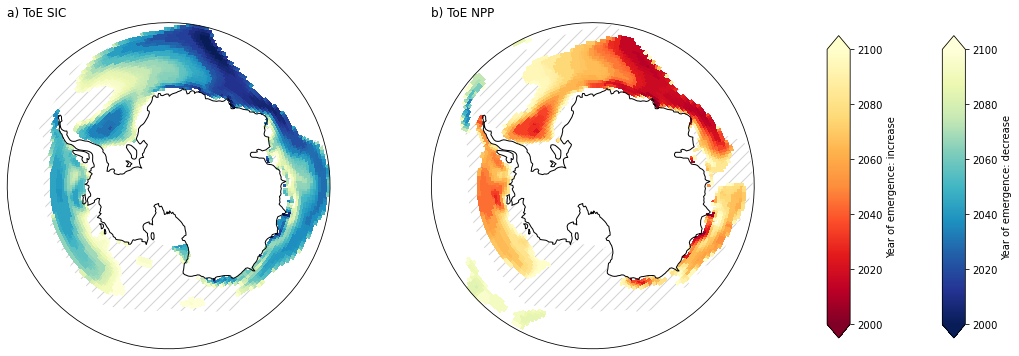

In [42]:
fig = plt.figure(figsize=(16,6))

#########################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE SIC', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_ondjfm)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax.set_boundary(circle, transform=ax.transAxes)

ax.coastlines('110m',linewidth=1)

######## ToE NPP increase #################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE NPP', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_ondjfm)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_ondjfm)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label='Year of emergence: decrease')
#fig.savefig('/glade/work/kristenk/figs/fig_TOE_Krill_growth_pot.png', bbox_inches='tight', dpi=300, format='png');

### Make some line plots to go with the maps

In [43]:
ts_SIZ = xr.Dataset()


v='IFRAC_ONDJFM'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_ONDJFM'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

v='IFRAC_OND'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_OND'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

v='IFRAC_JFM'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_JFM'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

v='IFRAC_AMJ'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_AMJ'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

v='IFRAC_JAS'
masked_area = area_km2.where(ds_siz_mask.SIZ==1)
masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
masked_area['nlat'] = ds_siz_mask.SIZ.nlat
masked_area['nlon'] = ds_siz_mask.SIZ.nlon
ts_SIZ['SIA_km2_JAS'] = (masked_fosi * masked_area).sum(dim=('nlon','nlat'))

##################################




for v in ['NPP_ONDJFM','NPP_OND','NPP_JFM','KGP_ONDJFM','KGP_OND','KGP_JFM','NPP_AMJ','NPP_JAS']:
        
    ######## Whole SIZ
    masked_area = area.where(ds_siz_mask.SIZ==1)
    masked_area['nlat'] = ds_siz_mask.SIZ.nlat
    masked_area['nlon'] = ds_siz_mask.SIZ.nlon
    
    masked_fosi = ds[v].where(ds_siz_mask.SIZ==1)
    
    ts_SIZ[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

### SIA

In [44]:
#SIZ
mean = ts_SIZ.SIA_km2_ONDJFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_ONDJFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice = ts_SIZ.SIA_km2_ONDJFM['time'].where(ts_SIZ.SIA_km2_ONDJFM.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val = mean-2*std
print(toe_ice, toe_ice_val)

<xarray.DataArray 'time' ()>
array(1990.) 7021936.908619408


In [45]:
#SIZ
mean = ts_SIZ.SIA_km2_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_OND.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice1 = ts_SIZ.SIA_km2_OND['time'].where(ts_SIZ.SIA_km2_OND.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val1 = mean-2*std
print(toe_ice1, toe_ice_val1)

<xarray.DataArray 'time' ()>
array(1992.) 11295187.02939993


In [46]:
#SIZ
mean = ts_SIZ.SIA_km2_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_JFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice2 = ts_SIZ.SIA_km2_JFM['time'].where(ts_SIZ.SIA_km2_JFM.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val2 = mean-2*std
print(toe_ice2, toe_ice_val2)

<xarray.DataArray 'time' ()>
array(1995.) 2486764.766670249


In [47]:
#SIZ
mean = ts_SIZ.SIA_km2_AMJ.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_AMJ.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice3 = ts_SIZ.SIA_km2_AMJ['time'].where(ts_SIZ.SIA_km2_AMJ.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val3 = mean-2*std
print(toe_ice3, toe_ice_val3)

<xarray.DataArray 'time' ()>
array(1989.) 8457819.298680644


In [48]:
#SIZ
mean = ts_SIZ.SIA_km2_JAS.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.SIA_km2_JAS.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_ice4 = ts_SIZ.SIA_km2_JAS['time'].where(ts_SIZ.SIA_km2_JAS.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_ice_val4 = mean-2*std
print(toe_ice4, toe_ice_val4)

<xarray.DataArray 'time' ()>
array(1987.) 13647194.523631714


### NPP

In [49]:
mean = ts_SIZ.NPP_ONDJFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_ONDJFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp = ts_SIZ.NPP_ONDJFM['time'].where(ts_SIZ.NPP_ONDJFM.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp_val = mean+2*std
print(toe_npp,toe_npp_val)

<xarray.DataArray 'time' ()>
array(1993.) 3609.7980095788307


In [50]:
mean = ts_SIZ.NPP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_OND.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp1 = ts_SIZ.NPP_OND['time'].where(ts_SIZ.NPP_OND.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp1_val = mean+2*std
print(toe_npp1,toe_npp1_val)

<xarray.DataArray 'time' ()>
array(1998.) 1461.5418602700784


In [51]:
mean = ts_SIZ.NPP_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_JFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp2 = ts_SIZ.NPP_JFM['time'].where(ts_SIZ.NPP_JFM.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp2_val = mean+2*std
print(toe_npp2,toe_npp2_val)

<xarray.DataArray 'time' ()>
array(nan) 2286.057882002542


In [52]:
mean = ts_SIZ.NPP_AMJ.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_AMJ.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp3 = ts_SIZ.NPP_AMJ['time'].where(ts_SIZ.NPP_AMJ.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp3_val = mean+2*std
print(toe_npp3,toe_npp3_val)

<xarray.DataArray 'time' ()>
array(2003.) 84.26950614073013


In [53]:
mean = ts_SIZ.NPP_JAS.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.NPP_JAS.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_npp4 = ts_SIZ.NPP_JAS['time'].where(ts_SIZ.NPP_JAS.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_npp4_val = mean+2*std
print(toe_npp4,toe_npp4_val)

<xarray.DataArray 'time' ()>
array(1987.) 33.40999467297917


### KGP

In [54]:
mean = ts_SIZ.KGP_ONDJFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.KGP_ONDJFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_kgp = ts_SIZ.KGP_ONDJFM['time'].where(ts_SIZ.KGP_ONDJFM.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_kgp_val = mean+2*std
print(toe_kgp,toe_kgp_val)

<xarray.DataArray 'time' ()>
array(2007.) 7.835014465184535


In [55]:
mean = ts_SIZ.KGP_OND.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.KGP_OND.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_kgp1 = ts_SIZ.KGP_OND['time'].where(ts_SIZ.KGP_OND.mean(dim='member_id') > mean+2*std).min(dim='time')
toe_kgp1_val = mean+2*std
print(toe_kgp1,toe_kgp1_val)

<xarray.DataArray 'time' ()>
array(2008.) 2.736267925339187


In [56]:
mean = ts_SIZ.KGP_JFM.isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ.KGP_JFM.isel(time=slice(0,30)).std(dim=('time','member_id')).values
toe_kgp2 = ts_SIZ.KGP_JFM['time'].where(ts_SIZ.KGP_JFM.mean(dim='member_id') < mean-2*std).min(dim='time')
toe_kgp2_val = mean-2*std
print(toe_kgp2,toe_kgp2_val)

<xarray.DataArray 'time' ()>
array(2087.) 3.7909922474012756


In [57]:
years = np.arange(1920,2100,1)

Text(0, 0.5, 'NPP (mol m$^{-2}$ season$^{-1}$)')

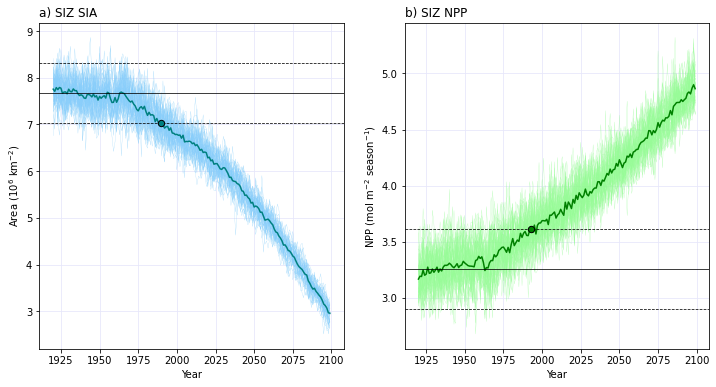

In [58]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.set_title("a) SIZ SIA", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax.plot(years, ts_SIZ['SIA_km2_ONDJFM'].isel(member_id=mem)*1e-6, color='lightskyblue',linewidth=0.2)
    
ax.plot(years, ts_SIZ['SIA_km2_ONDJFM'].mean(dim='member_id')*1e-6,
           color='teal', zorder=2)
mean = ts_SIZ['SIA_km2_ONDJFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_ONDJFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(toe_ice,toe_ice_val*1e-6,s=40,color='teal',edgecolor='black',zorder=3)
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("Area (10$^6$ km$^{-2}$)")

#######################

ax = fig.add_subplot(1, 2, 2)
ax.set_title("b) SIZ NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax.plot(years, ts_SIZ['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
    
ax.plot(years, ts_SIZ['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
mean = ts_SIZ['NPP_ONDJFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_ONDJFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(toe_npp,toe_npp_val*0.001,s=40,color='green',edgecolor='black',zorder=3)
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("NPP (mol m$^{-2}$ season$^{-1}$)")

Text(0, 0.5, 'NPP (mol m$^{-2}$ season$^{-1}$)')

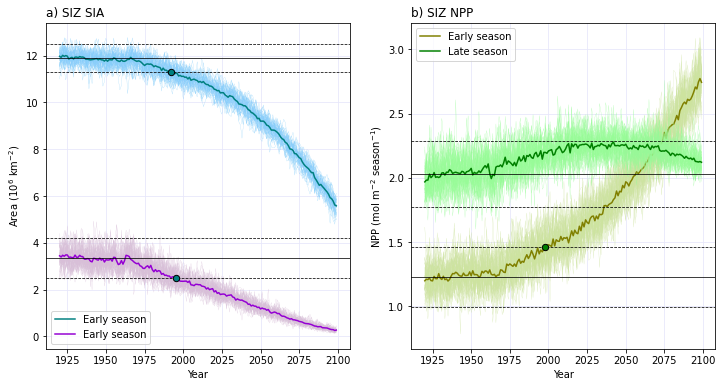

In [59]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.set_title("a) SIZ SIA", loc="left", fontsize=12)

for mem in np.arange(0,50,1):
    ax.plot(years, ts_SIZ['SIA_km2_OND'].isel(member_id=mem)*1e-6, color='lightskyblue',linewidth=0.2)
    
ax.plot(years, ts_SIZ['SIA_km2_OND'].mean(dim='member_id')*1e-6,color='teal', zorder=2,label='Early season')
mean = ts_SIZ['SIA_km2_OND'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_OND'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(toe_ice1,toe_ice_val1*1e-6,s=40,color='teal',edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax.plot(years, ts_SIZ['SIA_km2_JFM'].isel(member_id=mem)*1e-6, color='thistle',linewidth=0.2)
    
ax.plot(years, ts_SIZ['SIA_km2_JFM'].mean(dim='member_id')*1e-6,color='darkviolet', zorder=2,label='Early season')
mean = ts_SIZ['SIA_km2_JFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_JFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(toe_ice2,toe_ice_val2*1e-6,s=40,color='teal',edgecolor='black',zorder=3)
ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("Area (10$^6$ km$^{-2}$)")

#######################

ax = fig.add_subplot(1, 2, 2)
ax.set_title("b) SIZ NPP", loc="left", fontsize=12)

for mem in np.arange(0,50,1):
    ax.plot(years, ts_SIZ['NPP_OND'].isel(member_id=mem)*0.001, color=(205/255,227/255,159/255),linewidth=0.2)
    
ax.plot(years, ts_SIZ['NPP_OND'].mean(dim='member_id')*0.001,color='olive', zorder=2,label='Early season')
mean = ts_SIZ['NPP_OND'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_OND'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(toe_npp1,toe_npp1_val*0.001,s=40,color='green',edgecolor='black',zorder=3)


for mem in np.arange(0,50,1):
    ax.plot(years, ts_SIZ['NPP_JFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
    
ax.plot(years, ts_SIZ['NPP_JFM'].mean(dim='member_id')*0.001,color='green', zorder=2,label='Late season')
mean = ts_SIZ['NPP_JFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_JFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax.axhline(mean, color='black',linewidth=0.75)
ax.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax.scatter(toe_npp2,toe_npp2_val*0.001,s=40,color='green',edgecolor='black',zorder=3)

ax.legend()
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.set_xlabel("Year")
ax.set_ylabel("NPP (mol m$^{-2}$ season$^{-1}$)")

In [60]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

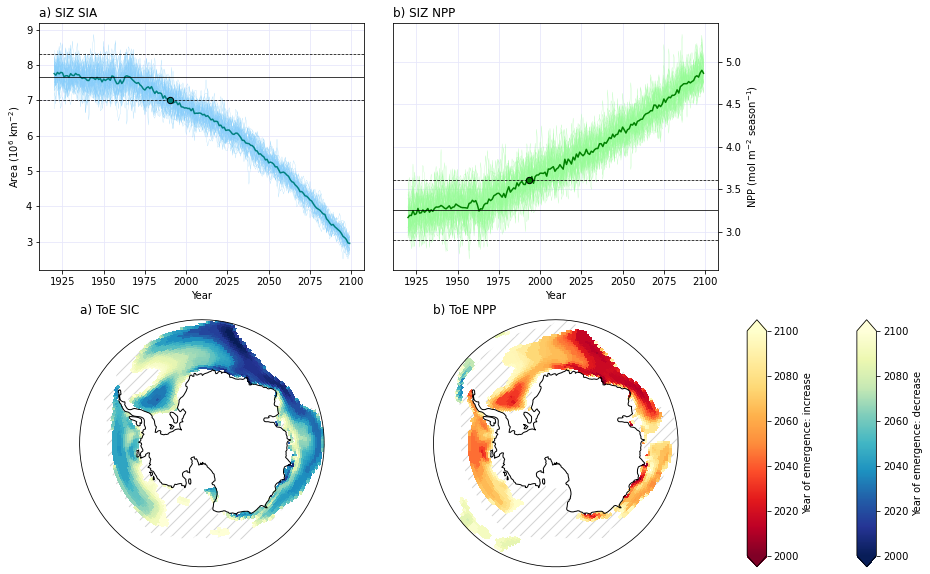

In [61]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(nrows=2, ncols=5, width_ratios=(1, 1, 0.06,0.1, 0.06),height_ratios=(1,1))

prj =ccrs.SouthPolarStereo()

ax_sia = plt.subplot(gs[0, 0])
ax_npp = plt.subplot(gs[0, 1])
ax_sic_map = plt.subplot(gs[1, 0], projection=prj)
ax_npp_map = plt.subplot(gs[1, 1], projection=prj)
cb1 = plt.subplot(gs[1,2])
cb2 = plt.subplot(gs[1,4])

#############

ax_sia.set_title("a) SIZ SIA", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax_sia.plot(years, ts_SIZ['SIA_km2_ONDJFM'].isel(member_id=mem)*1e-6, color='lightskyblue',linewidth=0.2)
    
ax_sia.plot(years, ts_SIZ['SIA_km2_ONDJFM'].mean(dim='member_id')*1e-6,
           color='teal', zorder=2)
mean = ts_SIZ['SIA_km2_ONDJFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_ONDJFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia.axhline(mean, color='black',linewidth=0.75)
ax_sia.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia.scatter(toe_ice,toe_ice_val*1e-6,s=40,color='teal',edgecolor='black',zorder=3)
ax_sia.xaxis.grid(True, which='major',color='lavender')
ax_sia.yaxis.grid(False, which='major',color='lavender');
ax_sia.set_xlabel("Year")
ax_sia.set_ylabel("Area (10$^6$ km$^{-2}$)")

##############

ax_npp.set_title("b) SIZ NPP", loc="left", fontsize=12)
for mem in np.arange(0,50,1):

    ax_npp.plot(years, ts_SIZ['NPP_ONDJFM'].isel(member_id=mem)*0.001, color='palegreen',linewidth=0.2)
    
ax_npp.plot(years, ts_SIZ['NPP_ONDJFM'].mean(dim='member_id')*0.001,
           color='green', zorder=2)
mean = ts_SIZ['NPP_ONDJFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_ONDJFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp.axhline(mean, color='black',linewidth=0.75)
ax_npp.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp.scatter(toe_npp,toe_npp_val*0.001,s=40,color='green',edgecolor='black',zorder=3)
ax_npp.xaxis.grid(True, which='major',color='lavender')
ax_npp.yaxis.grid(False, which='major',color='lavender');
ax_npp.set_xlabel("Year")
ax_npp.set_ylabel("NPP (mol m$^{-2}$ season$^{-1}$)")
ax_npp.tick_params(top=False, labeltop=False,bottom=True, labelbottom=True,right=True, labelright=True, left=False, labelleft=False)
ax_npp.yaxis.set_label_position("right")

#######################

ax_sic_map.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map.set_title('a) ToE SIC', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_ondjfm)

pc2 = ax_sic_map.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_sic_map.set_boundary(circle, transform=ax_sic_map.transAxes)

ax_sic_map.coastlines('110m',linewidth=1)

#################
ax_npp_map.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map.set_title('b) ToE NPP', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_ondjfm)

pc1 = ax_npp_map.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_ondjfm)

pc2 = ax_npp_map.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )

ax_npp_map.set_boundary(circle, transform=ax_npp_map.transAxes)

ax_npp_map.coastlines('110m',linewidth=1)

###########
cbar1 = fig.colorbar(pc1, cax=cb1,extend='both',label='Year of emergence: increase')

cbar1 = fig.colorbar(pc2, cax=cb2,extend='both',label='Year of emergence: decrease')




#fig.subplots_adjust(wspace=0.01,hspace=0.05)

### Figure 1, main text

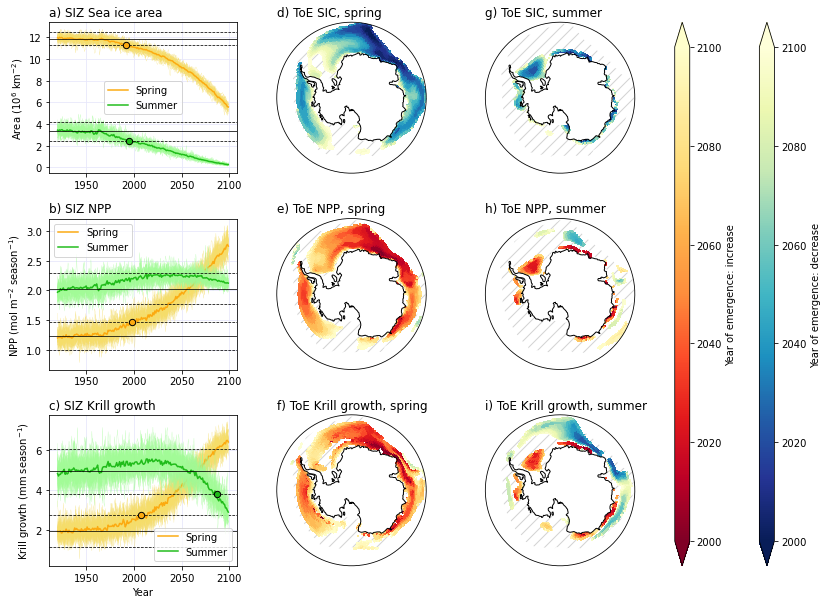

In [62]:
fig = plt.figure(figsize=(13, 10))
gs = gridspec.GridSpec(nrows=3, ncols=6, width_ratios=(1, 1, 1, 0.08,0.15, 0.08),height_ratios=(1,1,1))

prj =ccrs.SouthPolarStereo()

ax_sia_line = plt.subplot(gs[0, 0])
ax_npp_line = plt.subplot(gs[1, 0])
ax_kgp_line = plt.subplot(gs[2, 0])

ax_sic_map1 = plt.subplot(gs[0, 1], projection=prj)
ax_npp_map1 = plt.subplot(gs[1, 1], projection=prj)
ax_kgp_map1 = plt.subplot(gs[2, 1], projection=prj)

ax_sic_map2 = plt.subplot(gs[0, 2], projection=prj)
ax_npp_map2 = plt.subplot(gs[1, 2], projection=prj)
ax_kgp_map2 = plt.subplot(gs[2, 2], projection=prj)


cb1 = plt.subplot(gs[0:3,3])
cb2 = plt.subplot(gs[0:3,5])

spr_color_ens = (245/255,221/255,106/255)
spr_color_mean = (252/255,170/255,16/255)

sum_color_ens = (162/255,251/255,151/255)
sum_color_mean = (32/255,188/255,26/255)

##################################

ax_sia_line.set_title("a) SIZ Sea ice area", loc="left", fontsize=12)

for mem in np.arange(0,50,1):
    ax_sia_line.plot(years, ts_SIZ['SIA_km2_OND'].isel(member_id=mem)*1e-6, color=spr_color_ens,linewidth=0.2)
    
ax_sia_line.plot(years, ts_SIZ['SIA_km2_OND'].mean(dim='member_id')*1e-6,color=spr_color_mean, zorder=2,label='Spring')
mean = ts_SIZ['SIA_km2_OND'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_OND'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia_line.axhline(mean, color='black',linewidth=0.75)
ax_sia_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.scatter(toe_ice1,toe_ice_val1*1e-6,s=40,color=spr_color_mean,edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_sia_line.plot(years, ts_SIZ['SIA_km2_JFM'].isel(member_id=mem)*1e-6, color=sum_color_ens,linewidth=0.2)
    
ax_sia_line.plot(years, ts_SIZ['SIA_km2_JFM'].mean(dim='member_id')*1e-6,color=sum_color_mean, zorder=2,label='Summer')
mean = ts_SIZ['SIA_km2_JFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_JFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia_line.axhline(mean, color='black',linewidth=0.75)
ax_sia_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.scatter(toe_ice2,toe_ice_val2*1e-6,s=40,color=sum_color_mean,edgecolor='black',zorder=3)
ax_sia_line.legend()
ax_sia_line.xaxis.grid(True, which='major',color='lavender')
ax_sia_line.yaxis.grid(False, which='major',color='lavender');
#ax_sia_line.set_xlabel("Year")
ax_sia_line.set_ylabel("Area (10$^6$ km$^{-2}$)")

#####################

ax_npp_line.set_title("b) SIZ NPP", loc="left", fontsize=12)

for mem in np.arange(0,50,1):
    ax_npp_line.plot(years, ts_SIZ['NPP_OND'].isel(member_id=mem)*0.001, color=spr_color_ens,linewidth=0.2)
    
ax_npp_line.plot(years, ts_SIZ['NPP_OND'].mean(dim='member_id')*0.001,color=spr_color_mean, zorder=2,label='Spring')
mean = ts_SIZ['NPP_OND'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_OND'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp_line.axhline(mean, color='black',linewidth=0.75)
ax_npp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.scatter(toe_npp1,toe_npp1_val*0.001,s=40,color=spr_color_mean,edgecolor='black',zorder=3)
for mem in np.arange(0,50,1):
    ax_npp_line.plot(years, ts_SIZ['NPP_JFM'].isel(member_id=mem)*0.001, color=sum_color_ens,linewidth=0.2)
    
ax_npp_line.plot(years, ts_SIZ['NPP_JFM'].mean(dim='member_id')*0.001,color=sum_color_mean, zorder=2,label='Summer')
mean = ts_SIZ['NPP_JFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_JFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp_line.axhline(mean, color='black',linewidth=0.75)
ax_npp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.scatter(toe_npp2,toe_npp2_val*0.001,s=40,color='green',edgecolor='black',zorder=3)
ax_npp_line.legend()
ax_npp_line.xaxis.grid(True, which='major',color='lavender')
ax_npp_line.yaxis.grid(False, which='major',color='lavender');
#ax_npp_line.set_xlabel("Year")
ax_npp_line.set_ylabel("NPP (mol m$^{-2}$ season$^{-1}$)")

##################

ax_kgp_line.set_title("c) SIZ Krill growth", loc="left", fontsize=12)

for mem in np.arange(0,50,1):
    ax_kgp_line.plot(years, ts_SIZ['KGP_OND'].isel(member_id=mem), color=spr_color_ens,linewidth=0.2)
    
ax_kgp_line.plot(years, ts_SIZ['KGP_OND'].mean(dim='member_id'),color=spr_color_mean, zorder=2,label='Spring')
mean = ts_SIZ['KGP_OND'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ['KGP_OND'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_kgp_line.axhline(mean, color='black',linewidth=0.75)
ax_kgp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_kgp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_kgp_line.scatter(toe_kgp1,toe_kgp1_val,s=40,color=spr_color_mean,edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_kgp_line.plot(years, ts_SIZ['KGP_JFM'].isel(member_id=mem), color=sum_color_ens,linewidth=0.2)
    
ax_kgp_line.plot(years, ts_SIZ['KGP_JFM'].mean(dim='member_id'),color=sum_color_mean, zorder=2,label='Summer')
mean = ts_SIZ['KGP_JFM'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values
std = ts_SIZ['KGP_JFM'].isel(time=slice(0,30)).std(dim=('time','member_id')).values
ax_kgp_line.axhline(mean, color='black',linewidth=0.75)
ax_kgp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_kgp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_kgp_line.scatter(toe_kgp2,toe_kgp2_val,s=40,color=sum_color_mean,edgecolor='black',zorder=3)
ax_kgp_line.legend()
ax_kgp_line.xaxis.grid(True, which='major',color='lavender')
ax_kgp_line.yaxis.grid(False, which='major',color='lavender');
ax_kgp_line.set_xlabel("Year")
ax_kgp_line.set_ylabel("Krill growth (mm season$^{-1}$)")

############################################################################################## OND ToE maps

################# SIC ToE
ax_sic_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map1.set_title('d) ToE SIC, spring', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_ond)

pc2 = ax_sic_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_sic_map1.set_boundary(circle, transform=ax_sic_map1.transAxes)
ax_sic_map1.coastlines('110m',linewidth=1)

##########
ax_sic_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map2.set_title('g) ToE SIC, summer', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_jfm)

pc2 = ax_sic_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_sic_map2.set_boundary(circle, transform=ax_sic_map2.transAxes)
ax_sic_map2.coastlines('110m',linewidth=1)

######################

ax_npp_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map1.set_title('e) ToE NPP, spring', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_ond)
pc1 = ax_npp_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_ond)
pc2 = ax_npp_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_npp_map1.set_boundary(circle, transform=ax_npp_map1.transAxes)
ax_npp_map1.coastlines('110m',linewidth=1)

###
ax_npp_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map2.set_title('h) ToE NPP, summer', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_jfm)
pc1 = ax_npp_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_jfm)
pc2 = ax_npp_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_npp_map2.set_boundary(circle, transform=ax_npp_map2.transAxes)
ax_npp_map2.coastlines('110m',linewidth=1)

###################

ax_kgp_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_kgp_map1.set_title('f) ToE Krill growth, spring', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_kgp_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_kgp_ond)
pc1 = ax_kgp_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_kgp_ond)
pc2 = ax_kgp_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_kgp_map1.set_boundary(circle, transform=ax_kgp_map1.transAxes)
ax_kgp_map1.coastlines('110m',linewidth=1)
#################
ax_kgp_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_kgp_map2.set_title('i) ToE Krill growth, summer', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_kgp_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_kgp_jfm)
pc1 = ax_kgp_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_kgp_jfm)
pc2 = ax_kgp_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_kgp_map2.set_boundary(circle, transform=ax_kgp_map2.transAxes)
ax_kgp_map2.coastlines('110m',linewidth=1)

###########
cbar1 = fig.colorbar(pc1, cax=cb1,extend='both',label='Year of emergence: increase')

cbar1 = fig.colorbar(pc2, cax=cb2,extend='both',label='Year of emergence: decrease')

fig.subplots_adjust(hspace=0.3)

fig.savefig('/glade/work/kristenk/figs/Fig1_ToE_ice_npp_SIZ.png', bbox_inches='tight', dpi=300, format='png');

### Supplementary figures S2 and S3

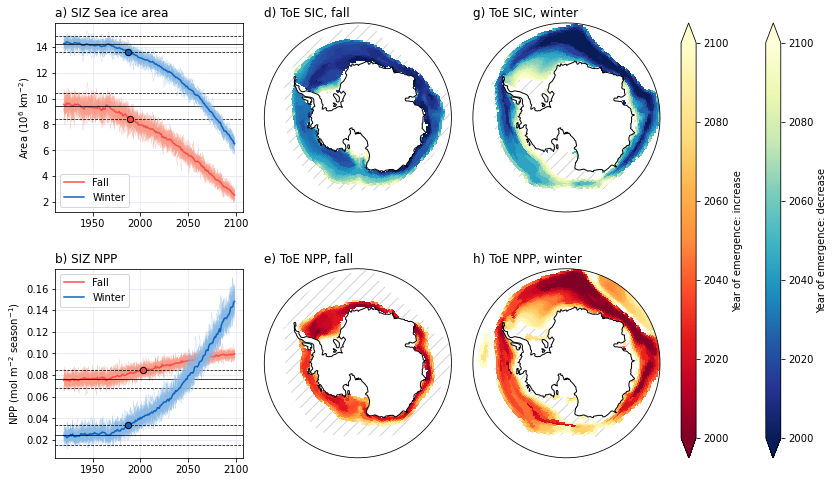

In [63]:
fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(nrows=2, ncols=6, width_ratios=(1, 1, 1, 0.08,0.15, 0.08),height_ratios=(1,1))

prj =ccrs.SouthPolarStereo()

ax_sia_line = plt.subplot(gs[0, 0])
ax_npp_line = plt.subplot(gs[1, 0])

ax_sic_map1 = plt.subplot(gs[0, 1], projection=prj)
ax_npp_map1 = plt.subplot(gs[1, 1], projection=prj)

ax_sic_map2 = plt.subplot(gs[0, 2], projection=prj)
ax_npp_map2 = plt.subplot(gs[1, 2], projection=prj)


cb1 = plt.subplot(gs[0:3,3])
cb2 = plt.subplot(gs[0:3,5])

fall_color_ens = (248/255,157/255,139/255)
fall_color_mean = (247/255,77/255,74/255)

wint_color_ens = (137/255,185/255,228/255)
wint_color_mean = (12/255,100/255,192/255)

##################################

ax_sia_line.set_title("a) SIZ Sea ice area", loc="left", fontsize=12)

for mem in np.arange(0,50,1):
    ax_sia_line.plot(years, ts_SIZ['SIA_km2_AMJ'].isel(member_id=mem)*1e-6, color=fall_color_ens,linewidth=0.2)
    
ax_sia_line.plot(years, ts_SIZ['SIA_km2_AMJ'].mean(dim='member_id')*1e-6,color=fall_color_mean, zorder=2,label='Fall')
mean = ts_SIZ['SIA_km2_AMJ'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_AMJ'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia_line.axhline(mean, color='black',linewidth=0.75)
ax_sia_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.scatter(toe_ice3,toe_ice_val3*1e-6,s=40,color=fall_color_mean,edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_sia_line.plot(years, ts_SIZ['SIA_km2_JAS'].isel(member_id=mem)*1e-6, color=wint_color_ens,linewidth=0.2)
    
ax_sia_line.plot(years, ts_SIZ['SIA_km2_JAS'].mean(dim='member_id')*1e-6,color=wint_color_mean, zorder=2,label='Winter')
mean = ts_SIZ['SIA_km2_JAS'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values *1e-6
std = ts_SIZ['SIA_km2_JAS'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*1e-6
ax_sia_line.axhline(mean, color='black',linewidth=0.75)
ax_sia_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_sia_line.scatter(toe_ice4,toe_ice_val4*1e-6,s=40,color=wint_color_mean,edgecolor='black',zorder=3)
ax_sia_line.legend()
ax_sia_line.xaxis.grid(True, which='major',color='lavender')
ax_sia_line.yaxis.grid(False, which='major',color='lavender');
#ax_sia_line.set_xlabel("Year")
ax_sia_line.set_ylabel("Area (10$^6$ km$^{-2}$)")

#####################

ax_npp_line.set_title("b) SIZ NPP", loc="left", fontsize=12)

for mem in np.arange(0,50,1):
    ax_npp_line.plot(years, ts_SIZ['NPP_AMJ'].isel(member_id=mem)*0.001, color=fall_color_ens,linewidth=0.2)
    
ax_npp_line.plot(years, ts_SIZ['NPP_AMJ'].mean(dim='member_id')*0.001,color=fall_color_mean, zorder=2,label='Fall')
mean = ts_SIZ['NPP_AMJ'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_AMJ'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp_line.axhline(mean, color='black',linewidth=0.75)
ax_npp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.scatter(toe_npp3,toe_npp3_val*0.001,s=40,color=fall_color_mean,edgecolor='black',zorder=3)

for mem in np.arange(0,50,1):
    ax_npp_line.plot(years, ts_SIZ['NPP_JAS'].isel(member_id=mem)*0.001, color=wint_color_ens,linewidth=0.2)
ax_npp_line.plot(years, ts_SIZ['NPP_JAS'].mean(dim='member_id')*0.001,color=wint_color_mean, zorder=2,label='Winter')
mean = ts_SIZ['NPP_JAS'].isel(time=slice(0,30)).mean(dim=('time','member_id')).values*0.001
std = ts_SIZ['NPP_JAS'].isel(time=slice(0,30)).std(dim=('time','member_id')).values*0.001
ax_npp_line.axhline(mean, color='black',linewidth=0.75)
ax_npp_line.axhline(mean+2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.axhline(mean-2*std, color='black',linestyle='--',linewidth=0.75)
ax_npp_line.scatter(toe_npp4,toe_npp4_val*0.001,s=40,color=wint_color_mean,edgecolor='black',zorder=3)
ax_npp_line.legend()
ax_npp_line.xaxis.grid(True, which='major',color='lavender')
ax_npp_line.yaxis.grid(False, which='major',color='lavender');
#ax_npp_line.set_xlabel("Year")
ax_npp_line.set_ylabel("NPP (mol m$^{-2}$ season$^{-1}$)")


############################################################################################## OND ToE maps

################# SIC ToE
ax_sic_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map1.set_title('d) ToE SIC, fall', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_amj)

pc2 = ax_sic_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_sic_map1.set_boundary(circle, transform=ax_sic_map1.transAxes)
ax_sic_map1.coastlines('110m',linewidth=1)

##########
ax_sic_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_sic_map2.set_title('g) ToE SIC, winter', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_sic_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_ice_jas)

pc2 = ax_sic_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_sic_map2.set_boundary(circle, transform=ax_sic_map2.transAxes)
ax_sic_map2.coastlines('110m',linewidth=1)

######################

ax_npp_map1.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map1.set_title('e) ToE NPP, fall', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map1.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_amj)
pc1 = ax_npp_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_amj)
pc2 = ax_npp_map1.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_npp_map1.set_boundary(circle, transform=ax_npp_map1.transAxes)
ax_npp_map1.coastlines('110m',linewidth=1)

###
ax_npp_map2.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_npp_map2.set_title('h) ToE NPP, winter', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax_npp_map2.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_up_npp_jas)
pc1 = ax_npp_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=2000,vmax=2100
                  )
lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_npp_jas)
pc2 = ax_npp_map2.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax_npp_map2.set_boundary(circle, transform=ax_npp_map2.transAxes)
ax_npp_map2.coastlines('110m',linewidth=1)

###################


###########
cbar1 = fig.colorbar(pc1, cax=cb1,extend='both',label='Year of emergence: increase')

cbar1 = fig.colorbar(pc2, cax=cb2,extend='both',label='Year of emergence: decrease')

fig.subplots_adjust(hspace=0.3)

fig.savefig('/glade/work/kristenk/figs/FigS2_ToE_ice_npp_otherseas.png', bbox_inches='tight', dpi=300, format='png');

### another supplementary figure (SIT ToE)

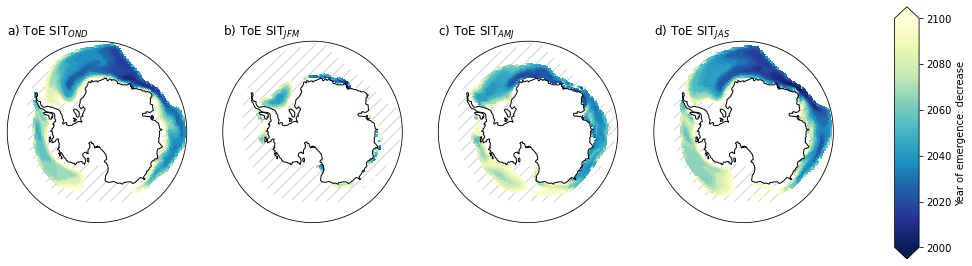

In [65]:
fig = plt.figure(figsize=(17,5))

########################################################
ax = fig.add_subplot(1,4,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE SIT$_{OND}$', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_ond)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


#########################################################
ax = fig.add_subplot(1,4,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE SIT$_{JFM}$', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_jfm)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


#########################################################
ax = fig.add_subplot(1,4,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('c) ToE SIT$_{AMJ}$', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_amj)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


#########################################################
ax = fig.add_subplot(1,4,4, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('d) ToE SIT$_{JAS}$', loc='left')
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons, lats, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ToE_down_SIT_jas)

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=2000,vmax=2100
                  )
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines('110m',linewidth=1)


fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label='Year of emergence: decrease')
fig.savefig('/glade/work/kristenk/figs/FigS3_ToEmaps_SIT_4seas.png', bbox_inches='tight', dpi=300, format='png');